In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.cbook import boxplot_stats
from sklearn.preprocessing import StandardScaler
import pprint
import scipy

ImportError: cannot import name 'LabelEncoder' from 'sklearn.decomposition' (/Users/kacperkreczko/Desktop/Datadrevet/IT3212/.venv/lib/python3.12/site-packages/sklearn/decomposition/__init__.py)

# Task 1: Data Exploration

Read data into csv

In [21]:
df = pd.read_csv("./electricity-consumption-raw.csv")


Display shape & 10 first rows

In [22]:
print(df.shape)

# 10 first rows
df.head(10)

(1899312, 4)


,datetime,substation,feeder,consumption
0,2017-01-01T00:00:00,A,A1,NaN
1,2017-01-01T01:00:00,A,A1,58.0
2,2017-01-01T02:00:00,A,A1,58.0
3,2017-01-01T03:00:00,A,A1,58.0
4,2017-01-01T04:00:00,A,A1,52.0
5,2017-01-01T05:00:00,A,A1,45.0
6,2017-01-01T06:00:00,A,A1,42.0
7,2017-01-01T07:00:00,A,A1,43.0
8,2017-01-01T08:00:00,A,A1,45.0
9,2017-01-01T09:00:00,A,A1,44.0


From this we can see that they have split the time-series in intervals of 3 hours, and a total of 8 points of data per day.
With a dataset containing 22445 rows of data, that gives us 

In [191]:
points_per_day = 8
dataset_in_days = df.shape[0] / points_per_day

print(f"Days in dataset: {dataset_in_days}")

dataset_in_weeks = dataset_in_days / 7 # 7 days per week

print(f"Weeks in dataset: {dataset_in_weeks}")

dataset_in_years = dataset_in_weeks / 52 # 52 weeks in a year

print(f"Years in dataset: {dataset_in_years}")


Days in dataset: 2805.625
Weeks in dataset: 400.80357142857144
Years in dataset: 7.707760989010989


Creating statistics of the dataset, for each column

In [258]:
df.describe()

,consumption
count,1.848947e+06
mean,1.018811e+02
std,6.286932e+01
min,7.000000e-01
25%,5.300000e+01
50%,8.900000e+01
75%,1.410000e+02
max,2.202000e+03


Identifyting missing values, outliers and unique values

In [6]:
for header in df.columns:
    print(f"# missing values in '{header}': {sum([x for x in df[header].isnull() if x == True])}")


# missing values in 'datetime': 0
# missing values in 'substation': 0
# missing values in 'feeder': 0
# missing values in 'consumption': 50365


# Task 2: Data Cleaning

Displaying where the missing values are located in the dataset.

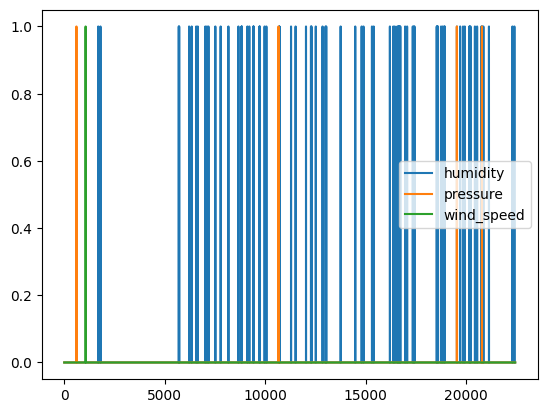

In [194]:
fig, ax = plt.subplots()

humidity_null = df['humidity'].isnull()
ax.plot(humidity_null)

pressure_null = df['pressure'].isnull()
ax.plot(pressure_null)

wind_speed_null = df['wind_speed'].isnull()
ax.plot(wind_speed_null)

ax.legend(['humidity', 'pressure', 'wind_speed'])


Example of a missing value in humidity

We choose to polynomially interpolate between the last known value and the next known, since it creates a nice mean datapoint between the known values. This fits the practical changes happening in the real world when it comes to humidity, wind_speed and pressure. As it follows the trends of both sides of the missing data value.


<Axes: >

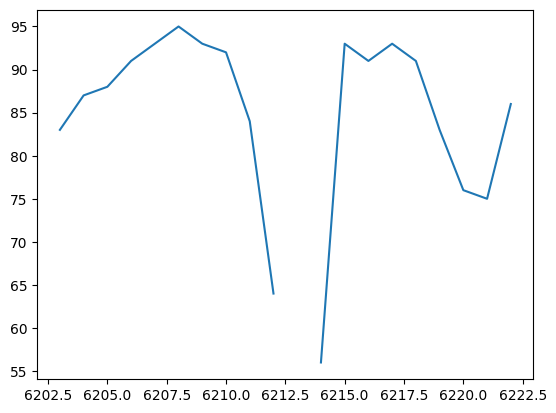

In [270]:
humidity_null = df['humidity'].isnull()

missing_values = []

for x in range(len(humidity_null)):
    if humidity_null[x] == True:
        missing_values.append(x)
        
i = 4

display_missing = df['humidity'][missing_values[i]-10:missing_values[i]+10]

display_missing.plot()


C:\Users\sfuij\AppData\Local\Temp\ipykernel_16916\2466392453.py:7: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  fixed_df_poly2 = df.interpolate(method="polynomial", order=2)


<Axes: >

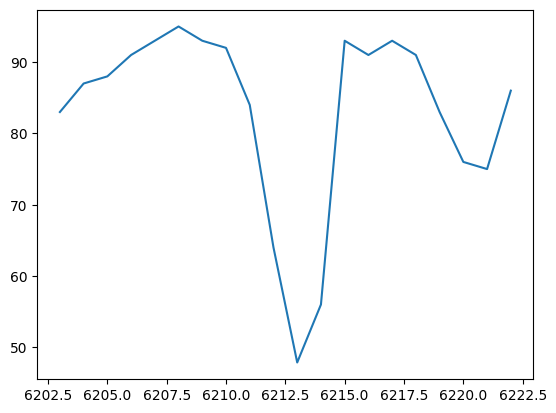

In [272]:
offset = 10

# Har kommentert ut denne fordi den er her kun for å ekspimentere.
# fixed_df_linear = df['humidity'].interpolate()
# fixed_df_linear[missing_values[i]-offset:missing_values[i]+offset].plot()

fixed_df_poly2 = df.interpolate(method="polynomial", order=2)

fixed_df_poly2[missing_values[i]-offset:missing_values[i]+offset]['humidity'].plot()

# Task 3: Handling outliers

Display IQR (Interquartile range), outliers shown by the black circle markers

[array([57., 12.]),
 array([ 89.        , 102.59733637]),
 array([7., 0.]),
 array([16., 29.]),
 array([19.4,  8. ]),
 array([27. , 38.4])]

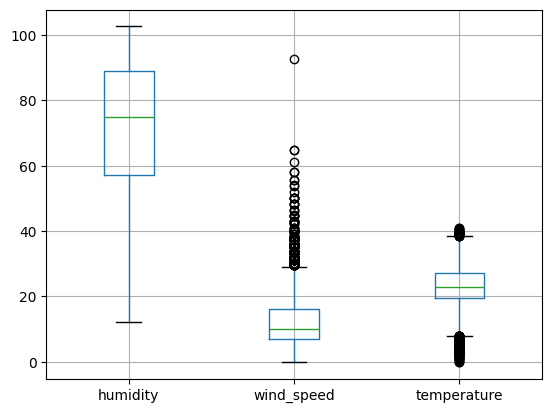

In [317]:
boxplot, bp = fixed_df_poly2.boxplot(column=['humidity', 'wind_speed', 'temperature'], return_type="both")

humidity_min_whisker = bp['whiskers'][0].get_ydata()[1]
humidity_max_whisker = bp['whiskers'][1].get_ydata()[1]

wind_speed_min_whisker = bp['whiskers'][2].get_ydata()[1]
wind_speed_max_whisker = bp['whiskers'][3].get_ydata()[1]

temperature_min_whisker = bp['whiskers'][4].get_ydata()[1]
temperature_max_whisker = bp['whiskers'][5].get_ydata()[1]

[whisker.get_ydata() for whisker in bp['whiskers']]


In [320]:
#Remove wind_speed outliers
removed_wind_speed = df[df['wind_speed'] < wind_speed_max_whisker][df['wind_speed'] > wind_speed_min_whisker]

# Remove humidity outliers
removed_humidity = removed_wind_speed[removed_wind_speed['humidity'] < humidity_max_whisker][removed_wind_speed['humidity'] > humidity_min_whisker]

# Remove temperature outliers, må justere grensen med 1 for å ta med outliers som har lik verdi som whiskers ??
removed_temperature = removed_humidity[removed_humidity['temperature'] < temperature_max_whisker][removed_humidity['temperature'] > temperature_min_whisker + 1]

C:\Users\sfuij\AppData\Local\Temp\ipykernel_16916\251093493.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  removed_wind_speed = df[df['wind_speed'] < wind_speed_max_whisker][df['wind_speed'] > wind_speed_min_whisker]
C:\Users\sfuij\AppData\Local\Temp\ipykernel_16916\251093493.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  removed_humidity = removed_wind_speed[removed_wind_speed['humidity'] < humidity_max_whisker][removed_wind_speed['humidity'] > humidity_min_whisker]
C:\Users\sfuij\AppData\Local\Temp\ipykernel_16916\251093493.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  removed_temperature = removed_humidity[removed_humidity['temperature'] < temperature_max_whisker][removed_humidity['temperature'] > temperature_min_whisker + 1]


array([56., 14.])

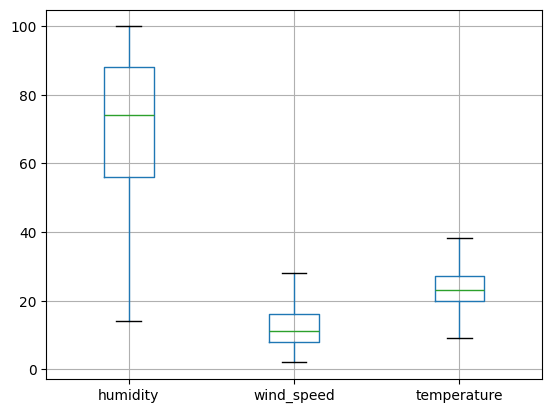

In [321]:
boxplot, bp = removed_temperature.boxplot(column=['humidity', 'wind_speed', 'temperature'], return_type="both")

bp['whiskers'][0].get_ydata()

# Task 4: Data Transformation

From the information we have available about this dataset, the substations are not ordinal and only unique identifiers for the specific substations. We have therefore chosen to apply one-shot encoding to them. Additionally, since the feeders seem like identifiers from information available to us, we've chosen to also apply one-hot encoding to them. This ensures theres no risk of the model assuming false relationships that might have accured if we used label encoding.

In [32]:
# Categorical columns to encode
categorical_columns = ['substation', 'feeder']

# Encode categorical columns
df_encoded = pd.get_dummies(df, columns=categorical_columns, dtype='int')

# Display the first few rows of the encoded dataframe
df_encoded.head()

,datetime,consumption,substation_A,substation_B,substation_C,substation_D,substation_E,substation_F,substation_G,substation_H,...,feeder_M2,feeder_M3,feeder_M4,feeder_M5,feeder_M6,feeder_M7,feeder_N1,feeder_N2,feeder_N3,feeder_N4
0,2017-01-01T00:00:00,NaN,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2017-01-01T01:00:00,58.0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2017-01-01T02:00:00,58.0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2017-01-01T03:00:00,58.0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2017-01-01T04:00:00,52.0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Since we don't have a way of knowing the lower and upper bounds of this dataset, since the consumption can easily get higher than our highest datapoint, we've chosen to use Z-score normalization. This ensures that future datapoints dont get cutoff to already predetermined bounds.

In [27]:
#Select numerical columns
numerical_columns = ['consumption']

#Initialize StandardScaler
scaler = StandardScaler()

#Normalize numerical columns
df_encoded[numerical_columns] = scaler.fit_transform(df_encoded[numerical_columns])

df_encoded.head()

,datetime,consumption,substation_A,substation_B,substation_C,substation_D,substation_E,substation_F,substation_G,substation_H,...,feeder_M2,feeder_M3,feeder_M4,feeder_M5,feeder_M6,feeder_M7,feeder_N1,feeder_N2,feeder_N3,feeder_N4
0,2017-01-01T00:00:00,NaN,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2017-01-01T01:00:00,-0.697974,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2017-01-01T02:00:00,-0.697974,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2017-01-01T03:00:00,-0.697974,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2017-01-01T04:00:00,-0.793410,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Feature scaling is necessary to use because it ensures faster convergence and prevents feature dominance. With scaled features, algorithms also perform better and lead to more accurate models.